In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 【問題1】全結合層のクラス化

In [2]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, layer):
        self.optimizer = optimizer
        self.layer = layer 
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.B = initializer.B(n_nodes2)
        self.W = initializer.W(n_nodes1, n_nodes2)
        
        self.HB = 0
        self.HW = 0
        
    def forward(self, X): #X or Z
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X #X or Z
        
        A = X @ self.W + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB = np.sum(dA, axis=0) / self.layer.batch_size
        dW = self.X.T @ dA / self.layer.batch_size
        dZ = dA @ self.W.T
        
        self.dB = dB
        self.dW = dW
        

        # 更新
        if self.layer.optimizer == "SGD":
            self.B, self.W = self.optimizer.update(self)
        elif self.layer.optimizer == "AdaGrad":
            self.B, self.W, self.HB, self.HW = self.optimizer.update(self)
            
        return dZ

# 【問題2】初期化方法のクラス化

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) #重みの初期値
        
        pass
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        
        B = self.sigma * np.random.randn(n_nodes2) #バイアスの初期値
        
        pass
        return B

# 【問題３】最適化方法のクラス化

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        B = layer.B - (self.lr * layer.dB) 
        W = layer.W - (self.lr * layer.dW)
        
        return B, W

# 【問題4】活性化関数のクラス化

In [5]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = 1 / (1 + np.exp(-A)) #シグモイド関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * ((1 - (1 / (1 + np.exp(-self.A)))) * (1 / (1 + np.exp(-self.A)))) #Aに関する損失の勾配
        return dA 

In [6]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = np.tanh(A) #ハイパボリックタンジェント関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2) #Aに関する損失の勾配
        return dA 

In [7]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        A = A - np.max(A, axis=1, keepdims=True) #オーバーフロー対策
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True) #ソフトマックス関数
        return Z
    
    def backward(self, Z, Y):
        dA = Z - Y  #Aに関する損失の勾配
        loss = -1 * np.sum(Y * np.log(Z + 1e-7)) / Z.shape[0] #交差エントロピー誤差

        return dA, loss

# 【問題5】ReLUクラスの作成
発展的な活性化関数を作成しましょう。ReLUという活性化関数によって、勾配消失の問題が解消され、層のディープ化が可能になりました。

\begin{align}
    f(x) = ReLU(x) = 
    \begin{cases}
        x　　(x>0)  \\
        0　　(x\leq0)
    \end{cases}  \\
    \frac{\partial f(x)}{\partial x} =
    \begin{cases}
        1　　(x>0) \\
        0　　(x\leq0)
    \end{cases}
\end{align}
本来、解析的には$x=0$で微分不可ですが、$f'(x=0)=0$とすることで対応しています。

In [8]:
class ReLU:
    def __init__(self):
        self.mask = None
        pass
    
    def forward(self, A):
        Z = np.maximum(0 + 1e-7, A)
        self.mask = (Z <= 0 + 1e-7)
        return Z 
    
    def backward(self, dZ):
        dZ[self.mask] = 0 + 1e-7
        dA = dZ 
        return dA

# 【問題6】重みの初期値

In [9]:
#Xavierの初期値
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1/np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2) #重みの初期値
        return W

    def B(self, n_nodes2):
        sigma = 1/np.sqrt(n_nodes2)
        B = sigma * np.random.randn(n_nodes2) #バイアスの初期値
        return B

In [10]:
#Heの初期値
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2/n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2) #重みの初期値
        return W
    
    def B(self, n_nodes2):
        sigma = np.sqrt(2/n_nodes2)
        B = sigma * np.random.randn(n_nodes2) #バイアスの初期値
        return B

# 【問題7】最適化手法
最適化手法には様々なものがあります。発展的なものの中でも比較的実装が簡単なAdaGradを実装してみましょう。

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

$W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。


$ H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\ $

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


$H_i^{\prime}$ : 更新した $H_i$

In [11]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        HB = layer.HB + layer.dB**2
        B = layer.B - (self.lr * (1/(np.sqrt(HB) + 1e-7)) * layer.dB)

        HW = layer.HW + layer.dW**2
        W = layer.W - (self.lr * (1/(np.sqrt(HW) + 1e-7)) * layer.dW)
        
        return B, W, HB, HW

# データの準備等

In [12]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [14]:
#平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

#正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [15]:
#データ分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(y_train.shape) # (48000, 784)

(48000, 784)
(48000,)


In [16]:
#yデータ　one-hot処理
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)

(48000, 10)
(12000, 10)


# 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [40]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, lr=10**-2, batch_size=20, activation_func="Tanh", optimizer="AdaGrad", 
                           n_nodes1=400, n_nodes2=200, n_layer=3, n_epoch=1, verbose = False):
        
        self.lr = lr #学習率
        self.batch_size = batch_size #バッチサイズ
        self.activation_func = activation_func #活性化関数の種類
        self.optimizer = optimizer #最適化手法
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_layer = n_layer #層の数
        self.n_epoch =n_epoch #エポック数
        self.loss_list = [] #損失を記録するリスト
        self.loss_list_val = [] #損失を記録するリスト(検証データ用)
        self.verbose = verbose
        
    
    def fit(self, X, y, X_val=None, y_val=None, cnt = 1):
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        if self.activation_func == "Tanh":
            activation = Tanh()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "Sigmoid":
            activation = Sigmoid()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "ReLU":
            activation = ReLU()
            initializer = HeInitializer() #Heの初期値
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer, self)
        self.activation1 = deepcopy(activation)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer, self)
        self.activation2 = deepcopy(activation)
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer, self)
        self.activation3 = Softmax()
         
        #fitを再帰させて学習データと検証データの両方を学習させる。検証データがあれば先に検証データを学習させる
        if X_val is None:
            get_mini_batch = GetMiniBatch(X, y, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        else:
            get_mini_batch = GetMiniBatch(X_val, y_val, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        
        #学習処理
        for i in range(self.n_epoch):
            loss_list = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える
                
                #forwardの処理
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                #backwardの処理
                dA3, loss = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                """
                Loss Curvを描くための処理
                """                
                loss_list.append(loss)
            
            if X_val is None:
                self.loss_list.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list)
            else:
                self.loss_list_val.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list_val)
                
        cnt += 1
        if cnt == 3 or X_val is None:
            return
        
        return self.fit(X, y, cnt = cnt) #検証データが入力されている場合は再帰させて学習データを学習させる。

    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

# 【問題9】学習と推定
ノード数や層の数、活性化関数を変えたネットワークを作成して、それぞれの結果を比較してみてください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

### N0.1 活性化関数：ReLU

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [19]:
sdnnc = ScratchDeepNeuralNetrowkClassifier(lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", 
                            n_nodes1=400, n_nodes2=200, n_layer=3, n_epoch=15, verbose = False)
sdnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [21]:
#テストデータ
pred = sdnnc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))
print("混同行列：")
print(confusion_matrix(y_test, pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, pred))

[7 2 1 ... 4 5 6]
正解率：0.98
混同行列：
[[ 971    0    0    2    0    3    1    1    2    0]
 [   0 1128    3    1    0    1    2    0    0    0]
 [   6    1 1010    1    1    0    2    6    5    0]
 [   0    0    2  988    0    2    0    4    6    8]
 [   2    0    4    0  959    0    3    2    2   10]
 [   2    0    0   10    2  867    4    1    4    2]
 [   7    3    1    1    5    4  936    0    1    0]
 [   1    1    7    1    0    0    0 1011    1    6]
 [   6    0    2    4    3    0    1    2  954    2]
 [   2    2    0    5    5    2    0    5    1  987]]
classification_report：
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98 

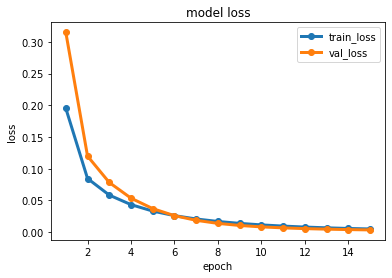

In [22]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(sdnnc.loss_list)+1), sdnnc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(sdnnc.loss_list_val)+1), sdnnc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### N0.2 活性化関数：Sigmoid

In [23]:
sdnnc = ScratchDeepNeuralNetrowkClassifier(lr=10**-2, batch_size=20, activation_func="Sigmoid", optimizer="AdaGrad", 
                            n_nodes1=400, n_nodes2=200, n_layer=3, n_epoch=15, verbose = False)
sdnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [24]:
#テストデータ
pred = sdnnc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))

[7 2 1 ... 4 5 6]
正解率：0.97


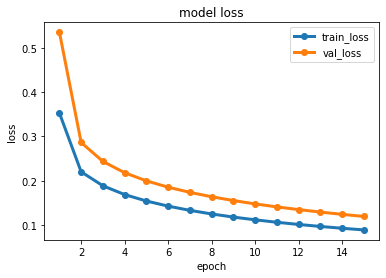

In [25]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(sdnnc.loss_list)+1), sdnnc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(sdnnc.loss_list_val)+1), sdnnc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### N0.3 活性化関数：Tanh

In [27]:
sdnnc = ScratchDeepNeuralNetrowkClassifier(lr=10**-2, batch_size=20, activation_func="Tanh", optimizer="AdaGrad", 
                            n_nodes1=400, n_nodes2=200, n_layer=3, n_epoch=15, verbose = False)
sdnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [28]:
#テストデータ
pred = sdnnc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))

[7 2 1 ... 4 5 6]
正解率：0.98


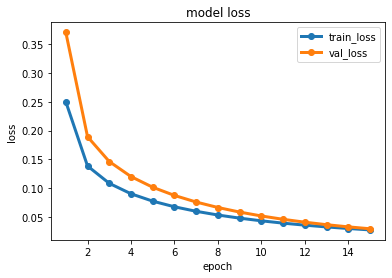

In [29]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(sdnnc.loss_list)+1), sdnnc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(sdnnc.loss_list_val)+1), sdnnc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### 今回の条件では活性化関数の違いによる正解率の差はほぼないが、lossの下がり具合を比較すると、ReLUが最も早い段階で下がっており、優秀であることが確認出来た。

### N0.4 活性化関数：ReLU、ノード数　１層目：５００、２層目：２５０

In [30]:
sdnnc = ScratchDeepNeuralNetrowkClassifier(lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", 
                            n_nodes1=500, n_nodes2=250, n_layer=3, n_epoch=15, verbose = False)
sdnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [31]:
#テストデータ
pred = sdnnc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))

[7 2 1 ... 4 5 6]
正解率：0.98


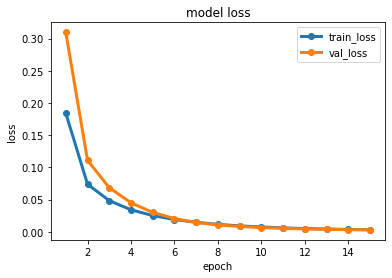

In [32]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(sdnnc.loss_list)+1), sdnnc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(sdnnc.loss_list_val)+1), sdnnc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### N0.5 活性化関数：ReLU、層数：６層

In [39]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, lr=10**-2, batch_size=20, activation_func="Tanh", optimizer="AdaGrad", n_nodes1=700, n_nodes2=600, 
                             n_nodes3=500, n_nodes4=400,  n_nodes5=300, n_nodes6=200, n_layer=6, n_epoch=15, verbose = False):
        
        self.lr = lr #学習率
        self.batch_size = batch_size #バッチサイズ
        self.activation_func = activation_func #活性化関数の種類
        self.optimizer = optimizer #最適化手法
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_nodes3 = n_nodes3 # 3層目のノード数
        self.n_nodes4 = n_nodes4 # 4層目のノード数
        self.n_nodes5 = n_nodes5 # 5層目のノード数
        self.n_nodes6 = n_nodes6 # 6層目のノード数 
        self.n_layer = n_layer #層の数
        self.n_epoch =n_epoch #エポック数
        self.loss_list = [] #損失を記録するリスト
        self.loss_list_val = [] #損失を記録するリスト(検証データ用)
        self.verbose = verbose
        
    
    def fit(self, X, y, X_val=None, y_val=None, cnt = 1):
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        if self.activation_func == "Tanh":
            activation = Tanh()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "Sigmoid":
            activation = Sigmoid()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "ReLU":
            activation = ReLU()
            initializer = HeInitializer() #Heの初期値
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer, self)
        self.activation1 = deepcopy(activation)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer, self)
        self.activation2 = deepcopy(activation)
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, initializer, optimizer, self)
        self.activation3 = deepcopy(activation)       
        self.FC4 = FC(self.n_nodes3, self.n_nodes4, initializer, optimizer, self)
        self.activation4 = deepcopy(activation)
        self.FC5 = FC(self.n_nodes4, self.n_nodes5, initializer, optimizer, self)
        self.activation5 = deepcopy(activation)
        self.FC6 = FC(self.n_nodes5, self.n_output, initializer, optimizer, self)
        self.activation6 = Softmax()
         
        #fitを再帰させて学習データと検証データの両方を学習させる。検証データがあれば先に検証データを学習させる
        if X_val is None:
            get_mini_batch = GetMiniBatch(X, y, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        else:
            get_mini_batch = GetMiniBatch(X_val, y_val, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        
        #学習処理
        for i in range(self.n_epoch):
            loss_list = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える
                
                #forwardの処理
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                A4 = self.FC4.forward(Z3)
                Z4 = self.activation4.forward(A4)
                A5 = self.FC5.forward(Z4)
                Z5 = self.activation5.forward(A5)
                A6 = self.FC6.forward(Z5)
                Z6 = self.activation6.forward(A6)

                #backwardの処理
                dA6, loss = self.activation6.backward(Z6, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ5 = self.FC6.backward(dA6)
                dA5 = self.activation5.backward(dZ5)
                dZ4 = self.FC5.backward(dA5)
                dA4 = self.activation4.backward(dZ4)
                dZ3 = self.FC4.backward(dA4)
                dA3 = self.activation3.backward(dZ3)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                """
                Loss Curvを描くための処理
                """                
                loss_list.append(loss)
            
            if X_val is None:
                self.loss_list.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list)
            else:
                self.loss_list_val.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list_val)
                
        cnt += 1
        if cnt == 3 or X_val is None:
            return
        
        return self.fit(X, y, cnt = cnt) #検証データが入力されている場合は再帰させて学習データを学習させる。

    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        A5 = self.FC5.forward(Z4)
        Z5 = self.activation5.forward(A5)
        A6 = self.FC6.forward(Z5)
        y = self.activation6.forward(A6)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [36]:
sdnnc = ScratchDeepNeuralNetrowkClassifier(lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", n_nodes1=700, n_nodes2=600, 
                             n_nodes3=500, n_nodes4=400,  n_nodes5=300, n_nodes6=200, n_layer=6, n_epoch=15, verbose = False)
sdnnc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [37]:
#テストデータ
pred = sdnnc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))

[7 2 1 ... 4 5 6]
正解率：0.98


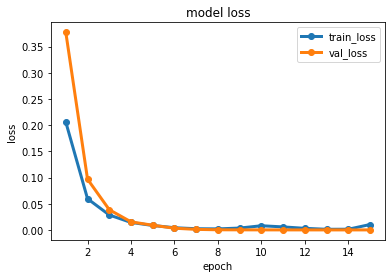

In [38]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(sdnnc.loss_list)+1), sdnnc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(sdnnc.loss_list_val)+1), sdnnc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### 層数を３→６層に増やすことで、かなり早い段階（epoch7あたり）でlossが収束しており、層数を増やすことの効果を確認出来た。ただし、学習にかなり時間が掛かるという背反もあり、より時間が掛からない実装方法についても考えて行きたい。